<a href="https://colab.research.google.com/github/Alf-caput/NFL2022_TacklePredictNN/blob/dev3/PracticaFinal_TacklingNFL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gdown

id = '1V_fIjH-WGHTVgyRkdNFkZ6XxiqDoaMrA'
folder = 'nfl-big-data-bowl-2024'
endpoint = '.zip'

url = f'https://drive.google.com/uc?id={id}'

output = folder + endpoint

gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1V_fIjH-WGHTVgyRkdNFkZ6XxiqDoaMrA
To: /content/nfl-big-data-bowl-2024.zip
100%|██████████| 293M/293M [00:03<00:00, 74.4MB/s]


'nfl-big-data-bowl-2024.zip'

In [2]:
from zipfile import ZipFile

with ZipFile(output, 'r') as zObject:
	zObject.extractall(folder)

In [3]:
import pandas as pd
import os

csv_files = [file for file in os.listdir(folder) if file.endswith('.csv')]
csv_files.sort()

In [4]:
print(csv_files)

['games.csv', 'players.csv', 'plays.csv', 'tackles.csv', 'tracking_week_1.csv', 'tracking_week_2.csv', 'tracking_week_3.csv', 'tracking_week_4.csv', 'tracking_week_5.csv', 'tracking_week_6.csv', 'tracking_week_7.csv', 'tracking_week_8.csv', 'tracking_week_9.csv']


Dentro de la carpeta nfl-big-data-bowl-2024 se encuentran los csv que utilizaremos, a continuación creamos un diccionario para facilitarnos el acceso a los diferentes dataframes (dfs).

In [5]:
dfs = {os.path.splitext(file)[0]: pd.read_csv(os.path.join(folder, file)) for file in csv_files}

In [6]:
dfs['games'].head(3)

,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,homeFinalScore,visitorFinalScore
0,2022090800,2022,1,09/08/2022,20:20:00,LA,BUF,10,31
1,2022091100,2022,1,09/11/2022,13:00:00,ATL,NO,26,27
2,2022091101,2022,1,09/11/2022,13:00:00,CAR,CLE,24,26


In [7]:
dfs['tracking_week_1'].head(3)

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event
0,2022090800,56,35472.0,Rodger Saffold,1,2022-09-08 20:24:05.200000,76.0,BUF,left,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NaN
1,2022090800,56,35472.0,Rodger Saffold,2,2022-09-08 20:24:05.299999,76.0,BUF,left,88.47,27.13,1.67,0.61,0.17,230.98,148.53,pass_arrived
2,2022090800,56,35472.0,Rodger Saffold,3,2022-09-08 20:24:05.400000,76.0,BUF,left,88.56,27.01,1.57,0.49,0.15,230.98,147.05,NaN


In [8]:
game_ids = dfs['tracking_week_1']['gameId'].unique()

In [9]:
df = dfs['tracking_week_1']
df[df['gameId'] == game_ids[0]]

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event
0,2022090800,56,35472.0,Rodger Saffold,1,2022-09-08 20:24:05.200000,76.0,BUF,left,88.370000,27.270000,1.62,1.15,0.16,231.74,147.90,NaN
1,2022090800,56,35472.0,Rodger Saffold,2,2022-09-08 20:24:05.299999,76.0,BUF,left,88.470000,27.130000,1.67,0.61,0.17,230.98,148.53,pass_arrived
2,2022090800,56,35472.0,Rodger Saffold,3,2022-09-08 20:24:05.400000,76.0,BUF,left,88.560000,27.010000,1.57,0.49,0.15,230.98,147.05,NaN
3,2022090800,56,35472.0,Rodger Saffold,4,2022-09-08 20:24:05.500000,76.0,BUF,left,88.640000,26.900000,1.44,0.89,0.14,232.38,145.42,NaN
4,2022090800,56,35472.0,Rodger Saffold,5,2022-09-08 20:24:05.599999,76.0,BUF,left,88.720000,26.800000,1.29,1.24,0.13,233.36,141.95,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79207,2022090800,3636,NaN,football,36,2022-09-08 23:05:27.099999,NaN,football,left,26.309999,28.690001,1.55,3.77,0.17,NaN,NaN,tackle
79208,2022090800,3636,NaN,football,37,2022-09-08 23:05:27.200000,NaN,football,left,26.209999,28.799999,1.23,3.14,0.15,NaN,NaN,NaN
79209,2022090800,3636,NaN,football,38,2022-09-08 23:05:27.299999,NaN,football,left,26.160000,28.959999,1.03,2.58,0.17,NaN,NaN,NaN
79210,2022090800,3636,NaN,football,39,2022-09-08 23:05:27.400000,NaN,football,left,26.139999,29.190001,0.95,2.30,0.23,NaN,NaN,NaN


In [20]:
game_id_to_visualize = unique_game_ids[0]  # Puedes cambiar esto al game_id específico que desees visualizar
print(df[df['gameId'] == game_id_to_visualize])


           gameId  playId    nflId     displayName  frameId  \
0      2022090800      56  35472.0  Rodger Saffold        1   
1      2022090800      56  35472.0  Rodger Saffold        2   
2      2022090800      56  35472.0  Rodger Saffold        3   
3      2022090800      56  35472.0  Rodger Saffold        4   
4      2022090800      56  35472.0  Rodger Saffold        5   
...           ...     ...      ...             ...      ...   
79207  2022090800    3636      NaN        football       36   
79208  2022090800    3636      NaN        football       37   
79209  2022090800    3636      NaN        football       38   
79210  2022090800    3636      NaN        football       39   
79211  2022090800    3636      NaN        football       40   

                             time  jerseyNumber      club playDirection  \
0      2022-09-08 20:24:05.200000          76.0       BUF          left   
1      2022-09-08 20:24:05.299999          76.0       BUF          left   
2      2022-09-08 

In [21]:
print(df[df['gameId'] == game_id_to_visualize][['x', 'y']])


               x          y
0      88.370000  27.270000
1      88.470000  27.130000
2      88.560000  27.010000
3      88.640000  26.900000
4      88.720000  26.800000
...          ...        ...
79207  26.309999  28.690001
79208  26.209999  28.799999
79209  26.160000  28.959999
79210  26.139999  29.190001
79211  26.120001  29.350000

[79212 rows x 2 columns]


In [22]:
print("x min/max:", df['x'].min(), df['x'].max())
print("y min/max:", df['y'].min(), df['y'].max())


x min/max: -1.27 120.16
y min/max: -4.62 58.25


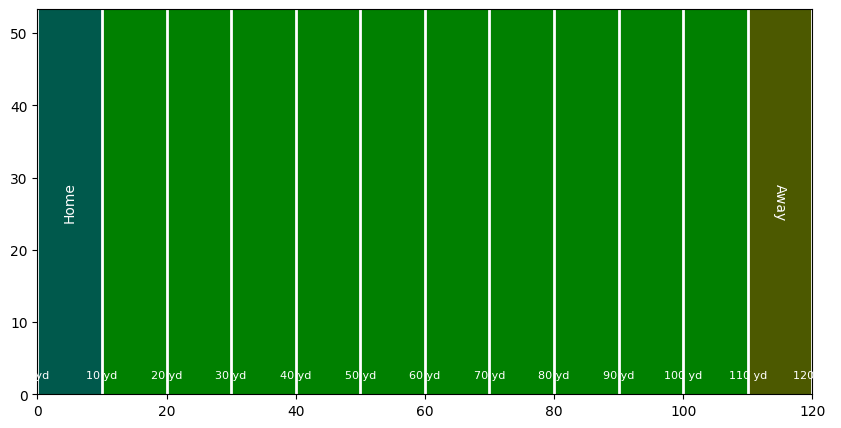

In [49]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(10, 5))
ax.set_facecolor('green')
plt.xlim(0, 120)
plt.ylim(0, 53.3)

# representacion yrds
for yard_line in range(0, 130, 10):
    color = 'white' if yard_line % 10 == 0 else 'green'
    plt.axvline(x=yard_line, color=color, linestyle='-', linewidth=2)
    plt.text(yard_line, 2, f'{yard_line} yd', color='white', ha='center', va='bottom', fontsize=8)

#home y away
plt.axvspan(0, 10, facecolor='blue', alpha=0.3)
plt.axvspan(110, 120, facecolor='red', alpha=0.3)
plt.text(5, 26.7, 'Home', color='white', ha='center', va='center', fontsize=10, rotation=90)
plt.text(115, 26.7, 'Away', color='white', ha='center', va='center', fontsize=10, rotation=-90)


plt.show()
